# Courier Churn: Data Preparation and EDA

**Anaconda version** (! conda --version): conda 4.8.2<br>
**Python Version** (! python --version): Python 3.6.10 :: Anaconda custom (64-bit)




In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from math import ceil, floor
from itertools import product
%matplotlib inline

In [38]:
df_lifetime_date = pd.read_csv('Courier_lifetime_data.csv')
df_weekly_data = pd.read_csv('Courier_weekly_data.csv')

# The Problem
The manager of an important city needs to size the fleet of couriers in order to properly serve the orders we expect to get in the next few weeks. Since couriers (aka glovers) are free to work or to stop working at any moment, they approach you and ask which couriers in the city fleet we can expect to work in the next 3 weeks (the churn window) and which couriers are not likely to come back, a classic churn problem. In order to act on the insights you provide, the city manager will need to have the predictions of your model available at least a week in advance.

# Creation of churn variable:
As describe in the Task churn is defined as not working in week 9,10, and/or 11 meaning there would be no data entries for those couriers so by subseeting the weekly data by the condition week>=9 we obtain all couriers who did not churn. Using this information we can create a df_no_churn with all couriers and our has_churned column  and left join this df back to the orginal df. In a last step we fill the NAs in the column has_churned with 1 since these are the couriers who did not turn up in one of the weeks (9,10,11)  

# Data Preparation

In [39]:
df_no_churn = pd.DataFrame(df_weekly_data[df_weekly_data.week>=9].courier.unique(), columns=['courier'])
df_no_churn['has_churned'] = 0
df_churn = df_weekly_data.merge(df_no_churn, how='left', on=['courier'])
df_churn.fillna({'has_churned':1}, inplace=True)

Check if churn column was created correctly (result should be 1)


In [40]:
df_churn.groupby('courier')['has_churned'].nunique().sum() / len(df_churn.courier.unique())

1.0

In [41]:
df_churn.groupby('has_churned')['courier'].nunique()

has_churned
0.0    387
1.0    372
Name: courier, dtype: int64

Df seems pretty balanced with respect to churn which is good for the later prediction task


## Join with lifetime variables
If a courier is not part of df_weekly but part of df lifetime that would mean that he/she did not work over the last 12 weeks. And therefore already churned (churn window 3 weeks), hence, should not be part of this analysis.
Following this argumentation I left join the lifetime data to the df_churn. 


In [42]:
df_lifetime_date.rename(columns={'feature_1':'cat_one', 'feature_2':'age_maybe'}, inplace=True)
df_churn = pd.merge(df_churn, df_lifetime_date, how='left', on=['courier']) 

Following the final isntruction to create the dataset I remove all rows for weeks [8-11]


In [43]:
df_churn = df_churn[df_churn.week < 8]

When having a first look (df_churn.info()) at the df_churn the only column having NA's seem to be the column I called age_maybe. As this is an intrinsic feature and most likely not continuous I will bin it and replace unreasoanble values by NA's. My assumption is that this is age hence there should be no values smaller than 18 (max value 66.0 looks reasonable) 

In [44]:
df_churn.loc[df_churn.age_maybe <18 , 'age_maybe'] = None
labels = ['bin_18_25', 'bin_25_35', 'bin_35_45', 'bin_45_plus']
df_churn['age_bins'] =pd.cut(df_churn.age_maybe, bins=[18,25,35,45, np.inf], include_lowest=True, labels=labels)
df_churn['age_bins'] = df_churn.age_bins.astype('str')
df_churn.loc[df_churn.age_bins.isin(labels)==False , 'age_bins'] = 'no_age'

Checking now (df_churn.info())shows that age_bins does not have any NA's anymore

# EDA
I will take a closer look at the churn variable and its interactions with the other covariates answering questions related to churn like:
- What is the relationship between churn and non_churn in the dataset?
- How does churn correlate with weekly patterns? 
- Do churned and non-chunred couriers show different work patterns? 
- How does churn correlate with continuous variables?
- How does churn interact with the categorical features?

### What is the percentage of couriers that are marked as churned?

In [45]:
churn_ratio = round(df_churn[df_churn.has_churned==1].courier.nunique() / df_churn.courier.nunique(),2)
print(f"Percentage of couriers that are marked as churned {churn_ratio*100}%")

Percentage of couriers that are marked as churned 50.0%


### First I want to have an idea how couriers are distributed across weeks by churn and non-churn


Text(0.5, 0, 'Weeks ')

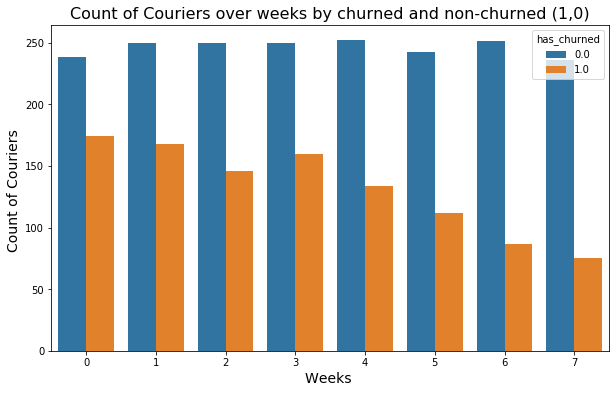

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='week'
            , y='courier'
            , hue='has_churned'
            , data=df_churn.groupby(['week', 'has_churned'])['courier'].nunique().reset_index()
            , ax=ax
           )
ax.set_title("Count of Couriers over weeks by churned and non-churned (1,0)", fontsize=16)
ax.set_ylabel("Count of Couriers ", fontsize=14)
ax.set_xlabel("Weeks ", fontsize=14)

Very intersting results:<br> 
It seems that there is already some churn happening during our training horizon since the counts of churned couriers are decreasing over weeks suggesting that some courieres that worked at the beginning week(0-3) did not work any week after that.
Couriers that did not churn showed a stable commitment over the week with very little fluctuation in the counts per week 



## Churn During Training Horizon
Lets check if there is some churn going on during our training data set (defined as being inactive for three weeks). In order to measure this, I will create a new churn variable similar to the first one but only for the last three weeks of the training data (churn window)

In [47]:
df_no_churn_training = pd.DataFrame(df_churn[df_churn.week>=5].courier.unique(), columns=['courier'])
df_no_churn_training['has_churned_training'] = 0
df_churn = df_churn.merge(df_no_churn_training, how='left', on=['courier'])
df_churn.fillna({'has_churned_training':1}, inplace=True)

Let's see how the churn variable in training (has_churned_training) relates to the target variable churn(has_churned)


In [48]:
df_churn.groupby(['has_churned', 'has_churned_training'])['courier'].nunique().reset_index()

has_churned  has_churned_training  courier
0          0.0                   0.0      335
1          0.0                   1.0       30
2          1.0                   0.0      170
3          1.0                   1.0      194

These results are very insight full:<br>
First, we see that less than ~8% (30/365)\*100 of couriers 
who did not churn did not work the last three weeks of our training horizon.
Second, and quite the opposite we see that ~53% (194/(194+170))*100 of couriers who churned did not work 
the last three weeks of the training period either.
This points in the direction that a three week churn window might be a good choice.
When seeing this numbers the variable has_churned_training could be a strong feature to determine the probability if a courier churns or not in the modelling exercise. 


## Work Patterns for churners and non-churners

Let's check if churned and non churned couriers work different amounts of week. This can lead to a feature for the later modelling exercise

Text(0.5, 0, 'Churn ')

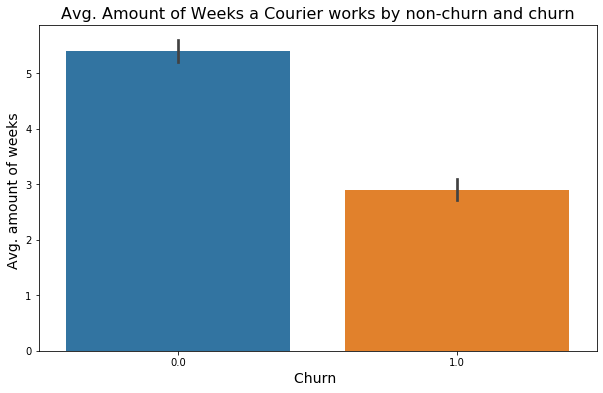

In [49]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='has_churned'
            , y='week' 
            ,data=df_churn.groupby(['has_churned', 'courier']).week.count().reset_index(), ax=ax)
ax.set_title("Avg. Amount of Weeks a Courier works by non-churn and churn", fontsize=16)
ax.set_ylabel("Avg. amount of weeks ", fontsize=14)
ax.set_xlabel("Churn ", fontsize=14)

We clearly see that churned couriers are work far less weeks what seems to be plausible and expected.
It seems to be a good feature for the later modelling

# Check churn with respect to the intrinsic variables

### Variable cat_one

Unique levels: ['a', 'b', 'c', 'd']

Text(0.5, 0, 'Category ')

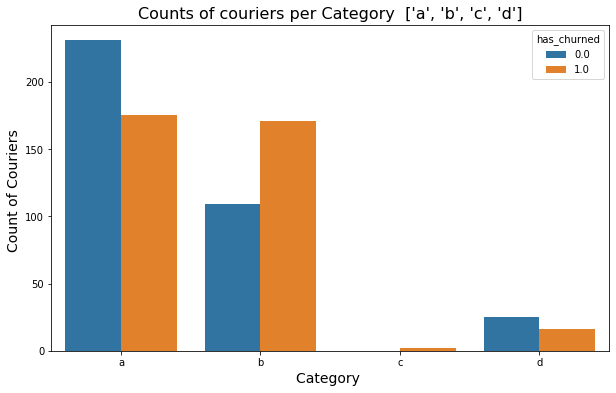

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='cat_one'
            , y='courier'
            , hue='has_churned'
            , order = ['a', 'b', 'c', 'd']
            , data=df_churn.groupby(['has_churned', 'cat_one']).courier.nunique().reset_index().sort_values(by=['has_churned', 'cat_one'])
            , ax=ax
           )
ax.set_title("Counts of couriers per Category  ['a', 'b', 'c', 'd']", fontsize=16)
ax.set_ylabel("Count of Couriers ", fontsize=14)
ax.set_xlabel("Category ", fontsize=14)



As there is no context given regarding the meaning of the different categories any interpretation is pure specualtion


### Variable age_maybe 

Supposing we are looking at age here

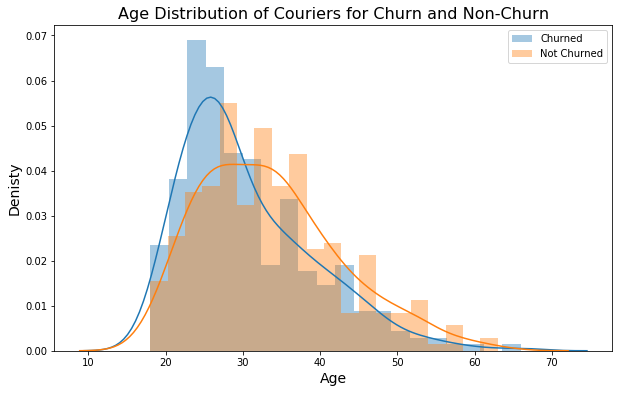

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
for value in df_churn.has_churned.unique():
    if value==1.0:
        label='Churned'
    else:
        label='Not Churned'
    sns.distplot(df_churn[(df_churn.has_churned==value) & (df_churn.age_maybe.isna()==False)].groupby('courier')['age_maybe'].mean()
                 , label=label
                 , bins=20
                 , ax=ax
                )
    ax.set_title("Age Distribution of Couriers for Churn and Non-Churn", fontsize=16)
    ax.set_ylabel("Denisty", fontsize=14)
    ax.set_xlabel("Age", fontsize=14)
    plt.legend()

In [52]:
mean_age_churn = np.mean(df_churn[(df_churn.has_churned==1) & (df_churn.age_maybe.isna()==False)].groupby('courier')['age_maybe'].mean())
mean_age_no_churn = np.mean(df_churn[(df_churn.has_churned==0) & (df_churn.age_maybe.isna()==False)].groupby('courier')['age_maybe'].mean())

From the two age distribution for churned and non churned several observations can be deducted.
First, churned couriers are on average 2.9 years younger than non churners (mean_age_churn - mean_age_no_churn).
Second, for both groups the mayority of observations fall between the age range of [20-40].
But each group shows long tails meaning that couriers can even be 45+.
For the later modelling exercise the binned variabled of age is going to be used but its distribution looks simialar
and the NA issue is adressed
(see below).

Text(0.5, 0, 'Age Bin ')

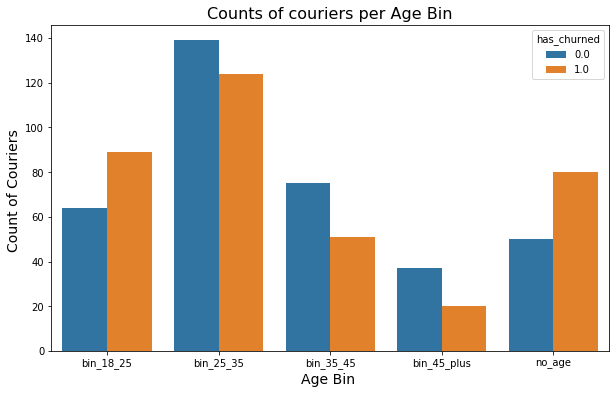

In [53]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='age_bins'
            , y='courier'
            , hue='has_churned'
#             , order = ['a', 'b', 'c', 'd']
            , data=df_churn.groupby(['has_churned', 'age_bins']).courier.nunique().reset_index().sort_values(by=['has_churned', 'age_bins'])
            , ax=ax
           )
ax.set_title("Counts of couriers per Age Bin", fontsize=16)
ax.set_ylabel("Count of Couriers ", fontsize=14)
ax.set_xlabel("Age Bin ", fontsize=14)

## Exploring features 1-17

On first glance I want to get a better understanding of the distribution of features 1-17
separated by churn and non churn since this could give some indiction which features might be 
valuable in the modelling step. Furthermore, I out put additional statistics (mean, median, std) for each feature separarted for each group(churn/non-churn). In a last step I perform a t-test for equality of means for each group.

In [54]:
performance_features = [col for col in df_churn.columns if col.startswith('feature')]

In [55]:
def describe_features(df, col):
    """
    Plot the distribution of a feature by for churn and non-churn separately. 
    Additionally, print out some statistical features of the distribution and
    perform a t-test for equality of means
    
    Keywords:
    df: df including the feature and the churn variable(0,1)
    col : column name of the feature
    """
    fig, ax = plt.subplots(figsize=(10,6))
    dict_status_stats = {}
    samples_for_t_test = []
    for value in df.has_churned.unique():
        if value==1.0:
            label='Churned'
        else:
            label='Not Churned'
        sns.distplot(df[(df.has_churned==value)][col]
                 , label=label
                 , bins=20
                 , ax=ax
                )
        mean = df[(df.has_churned==value)][col].mean()
        median = df[(df.has_churned==value)][col].median()
        std = df[(df.has_churned==value)][col].std()
        dict_status_stats[label] = mean, median, std
        sample = df[(df.has_churned==value)][col]
        samples_for_t_test.append(sample)
        
    results_ttest = ttest_ind(a=samples_for_t_test[0]
                          , b=samples_for_t_test[1]
                          , equal_var=False
                         )
    ax.set_title(f"{col} Distribution for Churn and Non-Churn", fontsize=16)
    ax.set_ylabel("Denisty", fontsize=14)
    ax.set_xlabel(f"{col}", fontsize=14)
    plt.legend()
    plt.show()
    for label in dict_status_stats.keys():
        print(f"{len(col)*str('*')}")
        print(f"{col}: {label}")
        print(f"Mean:{round(dict_status_stats[label][0],2)}")
        print(f"Median:{round(dict_status_stats[label][1],2)}")
        print(f"Std:{round(dict_status_stats[label][2],2)}")
    print("****************************************")
    print(f"Result of t-Test for equality of means: \nt-statistic: {round(results_ttest[0],2)} \np-value:{np.round(results_ttest[1],3)}")
    print(f"Results stat. significant at CI 95%: {results_ttest[1]<=0.05}")


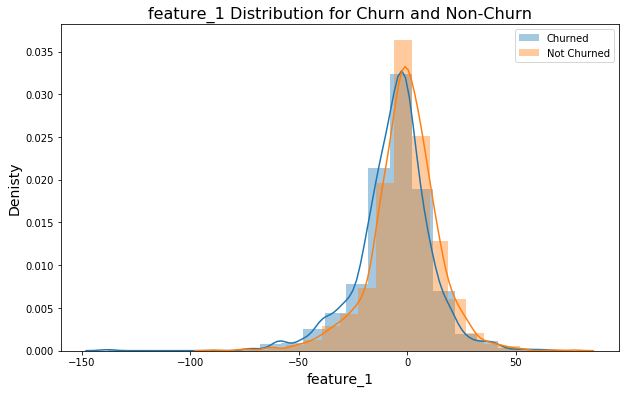

*********
feature_1: Churned
Mean:-6.06
Median:-4.0
Std:17.01
*********
feature_1: Not Churned
Mean:-1.2
Median:-1.0
Std:15.77
****************************************
Result of t-Test for equality of means: 
t-statistic: -7.68 
p-value:0.0
Results stat. significant at CI 95%: True


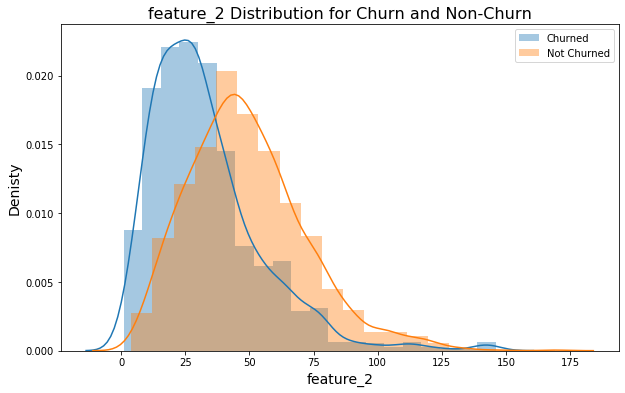

*********
feature_2: Churned
Mean:32.95
Median:29.0
Std:21.91
*********
feature_2: Not Churned
Mean:48.98
Median:47.0
Std:22.83
****************************************
Result of t-Test for equality of means: 
t-statistic: -18.9 
p-value:0.0
Results stat. significant at CI 95%: True


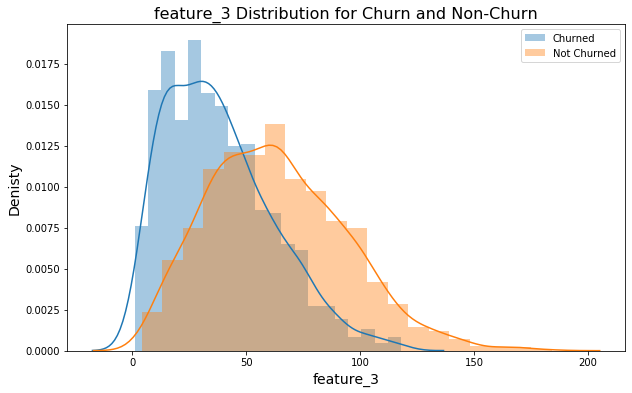

*********
feature_3: Churned
Mean:37.96
Median:35.0
Std:23.51
*********
feature_3: Not Churned
Mean:63.33
Median:61.0
Std:30.28
****************************************
Result of t-Test for equality of means: 
t-statistic: -25.52 
p-value:0.0
Results stat. significant at CI 95%: True


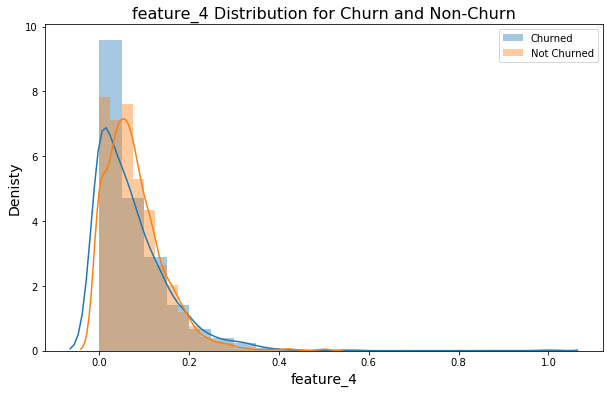

*********
feature_4: Churned
Mean:0.07
Median:0.05
Std:0.08
*********
feature_4: Not Churned
Mean:0.08
Median:0.07
Std:0.07
****************************************
Result of t-Test for equality of means: 
t-statistic: -1.87 
p-value:0.062
Results stat. significant at CI 95%: False


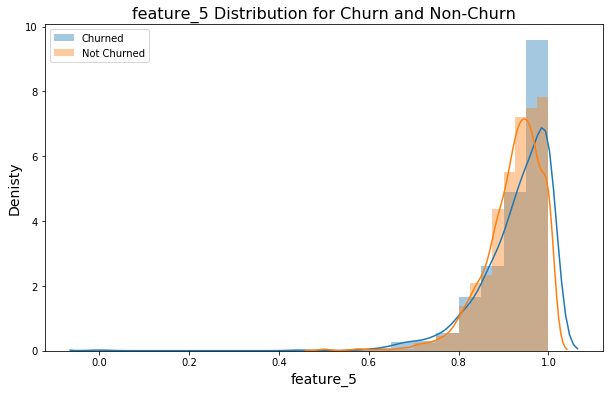

*********
feature_5: Churned
Mean:0.93
Median:0.95
Std:0.08
*********
feature_5: Not Churned
Mean:0.92
Median:0.93
Std:0.07
****************************************
Result of t-Test for equality of means: 
t-statistic: 1.87 
p-value:0.062
Results stat. significant at CI 95%: False


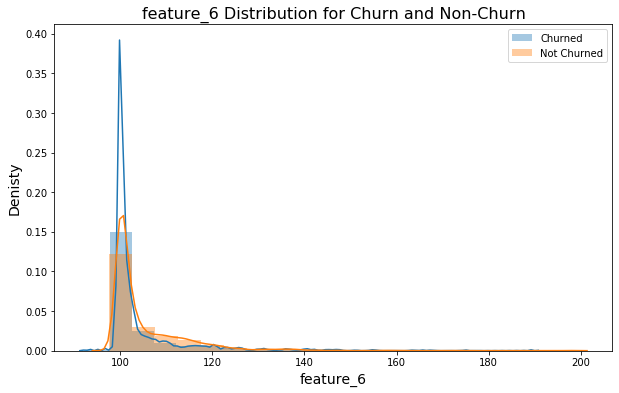

*********
feature_6: Churned
Mean:104.07
Median:100.0
Std:9.5
*********
feature_6: Not Churned
Mean:105.02
Median:101.15
Std:8.4
****************************************
Result of t-Test for equality of means: 
t-statistic: -2.74 
p-value:0.006
Results stat. significant at CI 95%: True


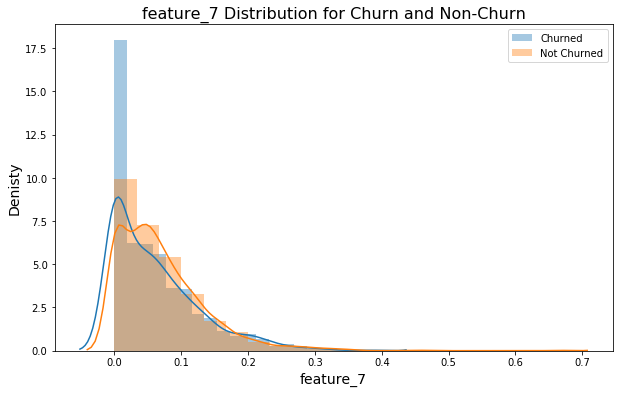

*********
feature_7: Churned
Mean:0.06
Median:0.04
Std:0.07
*********
feature_7: Not Churned
Mean:0.07
Median:0.06
Std:0.06
****************************************
Result of t-Test for equality of means: 
t-statistic: -3.7 
p-value:0.0
Results stat. significant at CI 95%: True


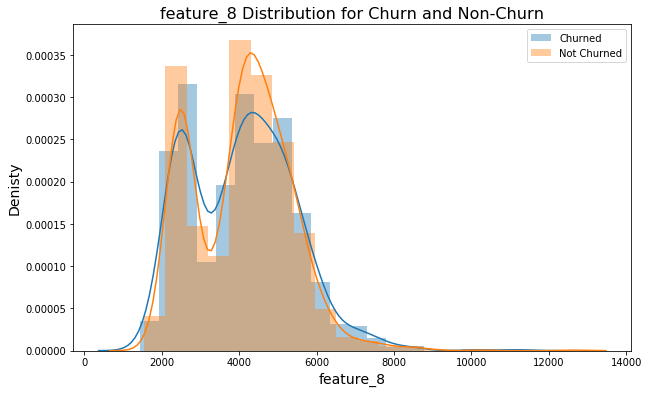

*********
feature_8: Churned
Mean:4065.92
Median:4119.68
Std:1362.61
*********
feature_8: Not Churned
Mean:4073.71
Median:4187.76
Std:1262.61
****************************************
Result of t-Test for equality of means: 
t-statistic: -0.15 
p-value:0.878
Results stat. significant at CI 95%: False


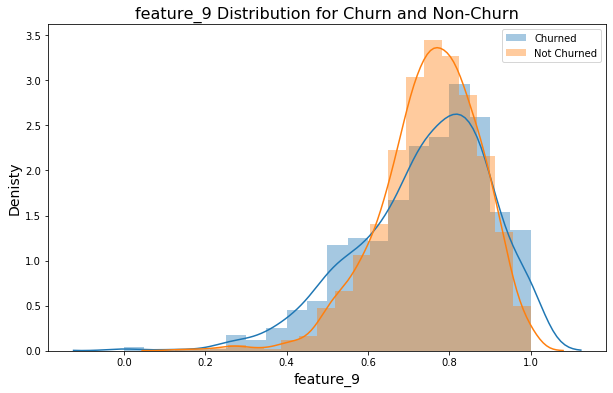

*********
feature_9: Churned
Mean:0.74
Median:0.76
Std:0.16
*********
feature_9: Not Churned
Mean:0.75
Median:0.76
Std:0.12
****************************************
Result of t-Test for equality of means: 
t-statistic: -2.51 
p-value:0.012
Results stat. significant at CI 95%: True


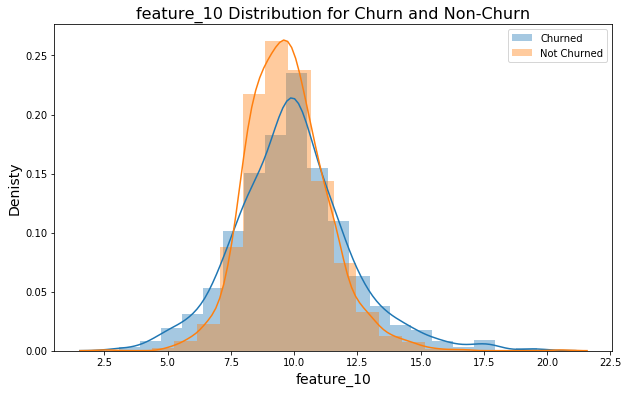

**********
feature_10: Churned
Mean:9.94
Median:9.87
Std:2.26
**********
feature_10: Not Churned
Mean:9.72
Median:9.62
Std:1.59
****************************************
Result of t-Test for equality of means: 
t-statistic: 2.85 
p-value:0.004
Results stat. significant at CI 95%: True


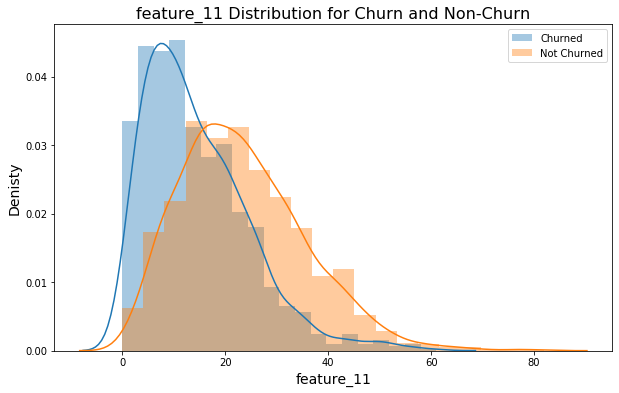

**********
feature_11: Churned
Mean:14.44
Median:12.0
Std:10.1
**********
feature_11: Not Churned
Mean:23.37
Median:22.0
Std:12.13
****************************************
Result of t-Test for equality of means: 
t-statistic: -21.57 
p-value:0.0
Results stat. significant at CI 95%: True


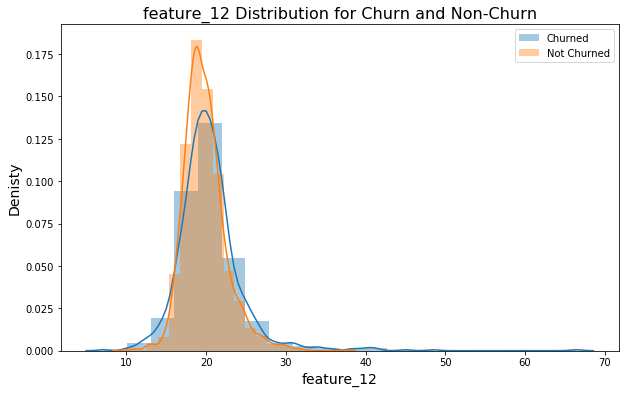

**********
feature_12: Churned
Mean:20.44
Median:20.0
Std:4.15
**********
feature_12: Not Churned
Mean:19.82
Median:19.48
Std:2.67
****************************************
Result of t-Test for equality of means: 
t-statistic: 4.39 
p-value:0.0
Results stat. significant at CI 95%: True


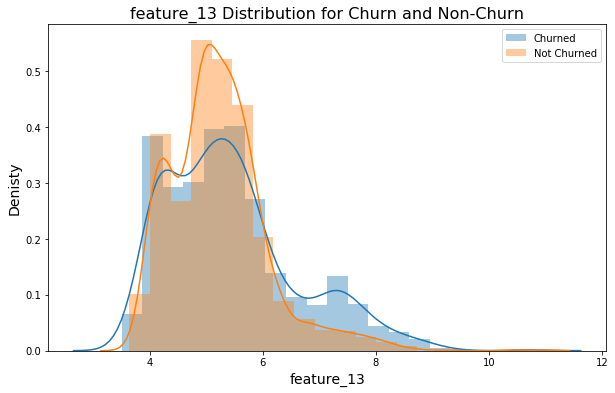

**********
feature_13: Churned
Mean:5.44
Median:5.25
Std:1.17
**********
feature_13: Not Churned
Mean:5.22
Median:5.14
Std:0.86
****************************************
Result of t-Test for equality of means: 
t-statistic: 5.39 
p-value:0.0
Results stat. significant at CI 95%: True


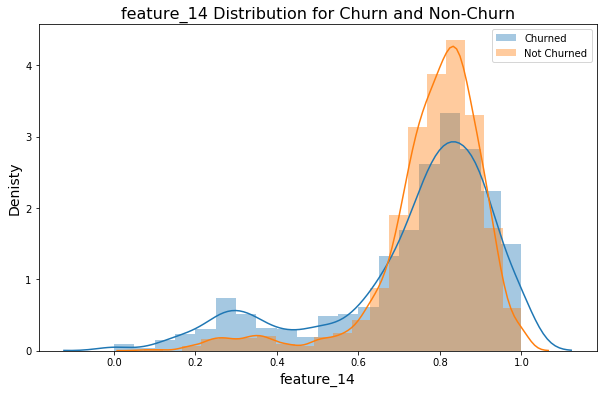

**********
feature_14: Churned
Mean:0.73
Median:0.79
Std:0.21
**********
feature_14: Not Churned
Mean:0.78
Median:0.81
Std:0.14
****************************************
Result of t-Test for equality of means: 
t-statistic: -6.62 
p-value:0.0
Results stat. significant at CI 95%: True


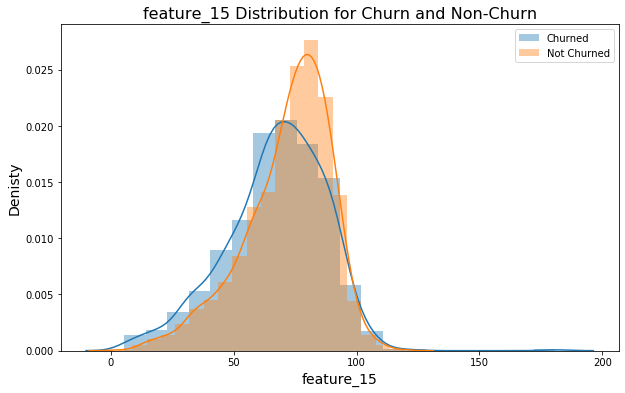

**********
feature_15: Churned
Mean:67.25
Median:69.3
Std:20.2
**********
feature_15: Not Churned
Mean:72.0
Median:75.26
Std:17.56
****************************************
Result of t-Test for equality of means: 
t-statistic: -6.45 
p-value:0.0
Results stat. significant at CI 95%: True


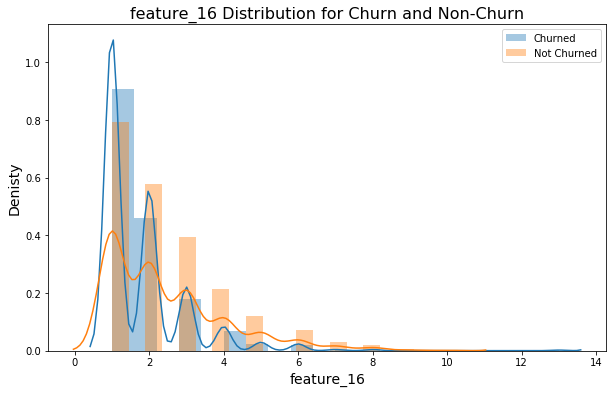

**********
feature_16: Churned
Mean:1.77
Median:1.0
Std:1.14
**********
feature_16: Not Churned
Mean:2.44
Median:2.0
Std:1.59
****************************************
Result of t-Test for equality of means: 
t-statistic: -13.52 
p-value:0.0
Results stat. significant at CI 95%: True


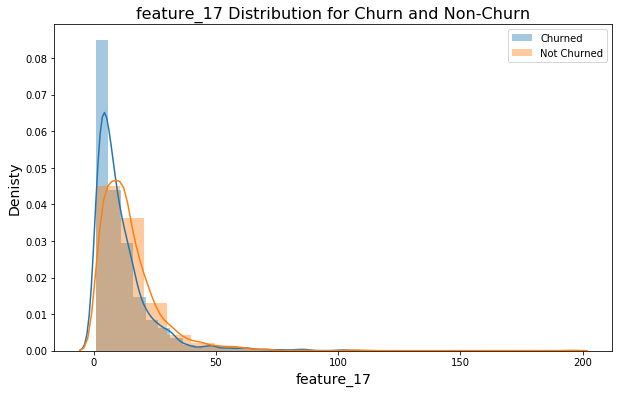

**********
feature_17: Churned
Mean:11.4
Median:8.0
Std:11.77
**********
feature_17: Not Churned
Mean:14.58
Median:12.0
Std:12.62
****************************************
Result of t-Test for equality of means: 
t-statistic: -6.92 
p-value:0.0
Results stat. significant at CI 95%: True


In [56]:
# For every feature apply describe_features fucntion
for col in performance_features:
    describe_features(df=df_churn, col=col)

### Comments :
Brief commnets to each of the feature<br/>
<br/>
**Feature_1**
- Result of the t-test is stat. significant suggesting that samples means are different
- Having said that, the two distribution are fairly well aligned
- The differences in means could be explained by extreme outliers which are as well visible when looking at the long tails of the distribution
- In any case, the feature will be included in the final modelling exercise

**Feature_2**
- In this case the two distributions are showing very different patterns
- As expected the t-test rejects the null hypothesis that both means are equal
- This feature could be valuable to differentiate churn and non-churn couriers

**Feature_3**
- Same conclusions as for feature_2

**Feature_4**
- In this case we cannot reject the null hypothesis at a CI of 95% that both means are equal
- This suggest that this feature might not be very suitible to distinguish churn and non-churn couriers
- In any case this will be observed and tested in the later modelling step

**Feature_5**
- Same conclusions as for feature_4 

**Feature_6**
- Same conclusions as for feature_1

**Feature_7**
- Result of the t-test is stat. significant suggesting that samples means are different
- It seems that values for churned couriers are more centered around 0 when comparng with non churned
- Potentially a good feature for the modelling exercise

**Feature_8**
- Same conclusions as for feature_4

**Feature_9**
- Similar conclusions as for feature_1

**Feature_10**
- Similar conclusions as for feature_1

**Feature_11**
- Same conclusions as for feature_2

**Feature_12**
- Same conclusions as for feature_1

**Feature_13**
- There seems to be some difference on the right tail of the dist. 

**Feature_14**
- We reject the the H0 suggesting that the means are not equal
- We see in the plot that churners are more likely to have values around 0.2-0.4 than non-churners

**Feature_15**
- We as well reject the H0 suggesting that the means are not equal
- The difference here seems quite substatial as well and could hint to a good tool for separating churners and non-churners 

**Feature_16**
- Does not seem to be a continuous variable more like a count (poission dist)
- Will be analysed separately 

**Feature_17**
- Same as Feature_15


**Comments regarding the t-test:**
<br/>
The t-test assumes independence of the two test groups. This is not necessarly the case here because non-churners could affect churners and vice versa in many different ways (i.e. competition) since they are operating in the same market.
For this reason the results of the t-test should be taken with a pinch of salt.


**Most Promising Features after visual inspection and t-tests**
- Feature 2,3, and 11


### Analysing Feature_16

In [57]:
# Mean value of feature 16 per courier for churned and non churned
df_mean_values_feature_16 = df_churn.groupby(['has_churned', 'courier'])['feature_16'].mean().reset_index().groupby('has_churned')['feature_16'].mean().reset_index()

In [58]:
df_mean_values_feature_16

has_churned  feature_16
0          0.0    2.266350
1          1.0    1.610655

Couriers who have churned have a lower count than non-churners

Text(0.5, 0, 'Churn')

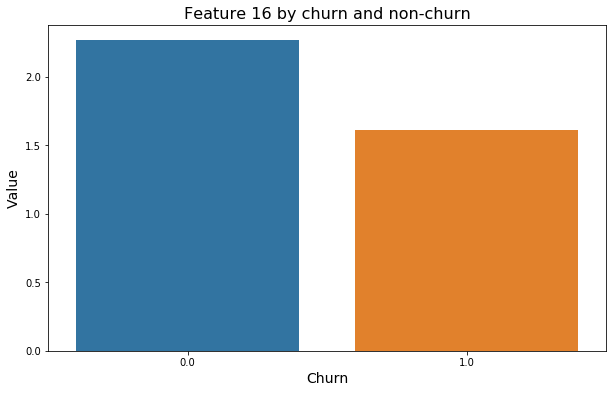

In [59]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='has_churned'
            , y='feature_16'
            , data=df_mean_values_feature_16
            , ax=ax
           )
ax.set_title("Feature 16 by churn and non-churn", fontsize=16)
ax.set_ylabel("Value", fontsize=14)
ax.set_xlabel("Churn", fontsize=14)

**Comment feature_16**
- Feature 16 shows quite some differences in avg.values for churned and non-churned couriers
- Might be a good feature for later


## Box Plot for further compaison of distributions  and extreme values

In [60]:
def boxplot_grid(columns_to_plot, comparison_variable, data_frame, title, figsize):
    """
    Outputs a figure including a boxplot for each the columns specified in columns_to_plot
    separated by the comparison_variable
    
    IN:
    columns_to_plot (list): continuous variables to be plotted, must be in data_frame
    comparison_variable (string): variable name of comparison variable
    data_frame (pandas df): DF including columns_to_plot and comparison_variable
    title (str): Title of plot
    figsize (tuple): Size of figure
    
    OUT:
    Grid Figure inluding boxplot for each variable in columns_to_plot
    """
    
    nr_rows = ceil(len(columns_to_plot)/2)
    counter=0
    fig, axes = plt.subplots(ncols=2, nrows=nr_rows, figsize=figsize)

    for i, j in product(range(nr_rows),  repeat=2):
        if counter < len(columns_to_plot):
            ax = sns.boxplot(x=comparison_variable
                             , y=columns_to_plot[counter]
                             , data=data_frame
                             , orient='v'
                             , ax=axes[j, i])
            if counter <= len(columns_to_plot):
                counter+=1
        else:
            break
    if len(columns_to_plot) % 2 > 0:
        fig.delaxes(axes[nr_rows-1][1])
    fig.suptitle(title, fontsize=(18), y=0.9)

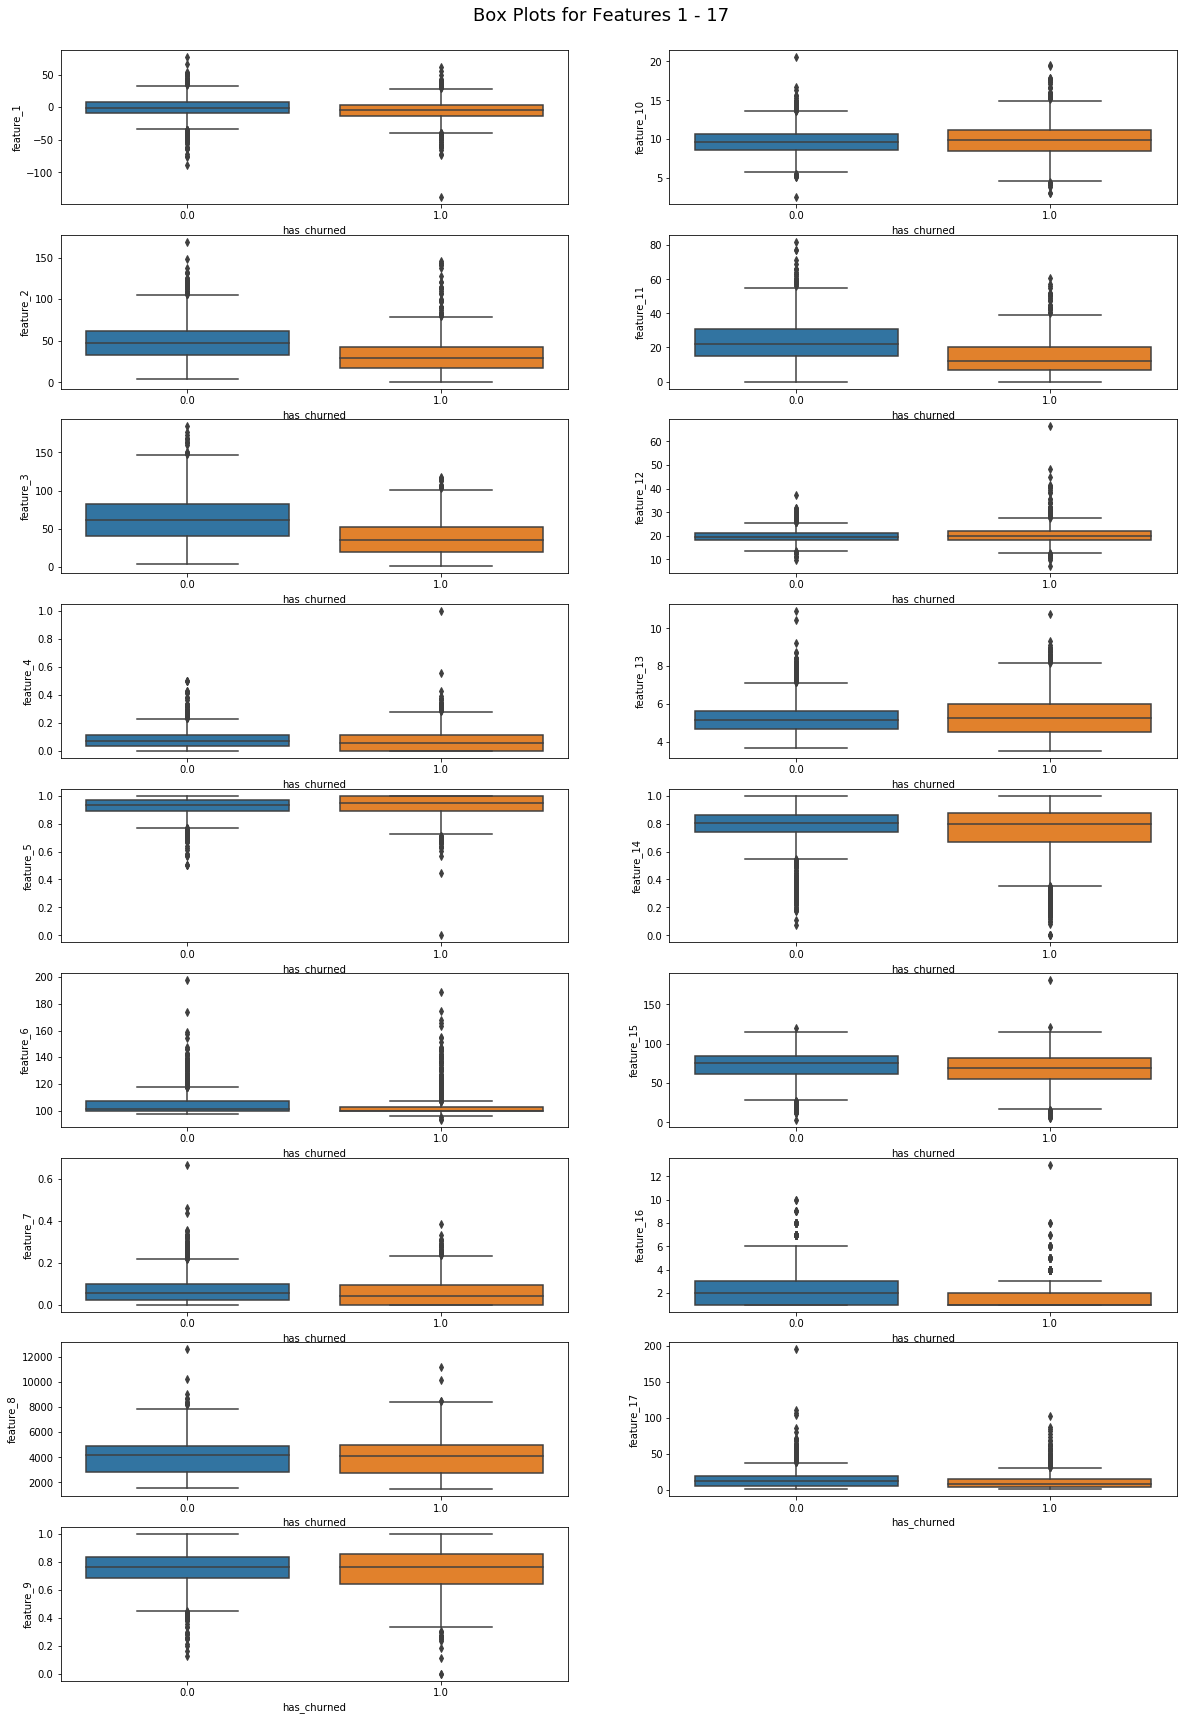

In [61]:
boxplot_grid(columns_to_plot=performance_features
             , comparison_variable = "has_churned"
             , data_frame = df_churn
             , title="Box Plots for Features 1 - 17"
             , figsize=(20,30)
            )

Observations:
- Feature 2,3,11 show the biggest differences in distributions between churners and non-churners by visiual inspection. This was expected when considering the results of the previous exercise where we compared each feature for churners and non-churners separately.
- There seem to be several extreme values (defined by the box-plot outlier definition e.g. for upper bound Q3 + 1.5IQR and for lower bound Q1-1.5IQR) for most covariates. However, and without knowledge regarding the meaning of the variables it is hard to tell if these are just extreme values out outliers which should be dealt with.

## Correlation among features
In this step I want to see how the correlation among the performance features where I will use a heatmap

Text(0.5, 1, 'Correlation Matrix for Features 1-17')

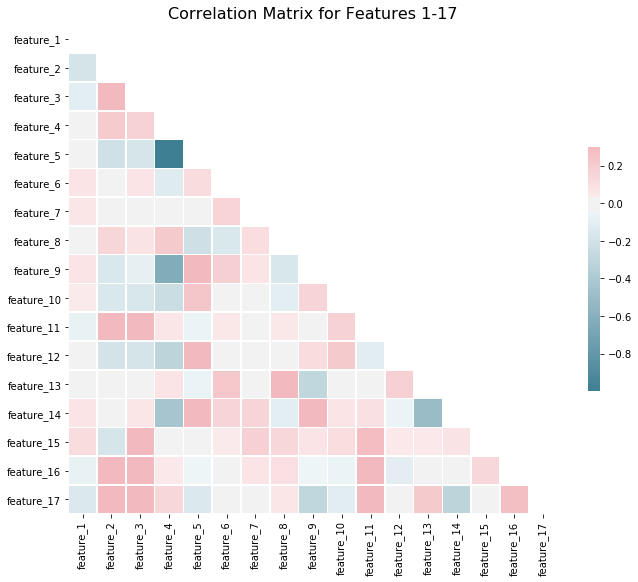

In [26]:
corr = df_churn[performance_features].corr()
# Generate a mask to show only have of the matrix
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Correlation Matrix for Features 1-17", fontsize=16)


Overall, the features do not seem to be too correlated which is good. However, feature 4 is higly correlated with feature 5 and mildly correlated with feature 9 and 14.
This can lead to potential multicollinearity issues when fitting a regression model.

In [27]:
df_churn[['feature_4', 'feature_5', 'feature_9', 'feature_14']].corr()

feature_4  feature_5  feature_9  feature_14
feature_4    1.000000  -1.000000  -0.630019   -0.434895
feature_5   -1.000000   1.000000   0.630022    0.434899
feature_9   -0.630019   0.630022   1.000000    0.765442
feature_14  -0.434895   0.434899   0.765442    1.000000

It seems that the following holds: feature_4 = 1 - feature_5 
Testing in the following:

In [28]:
print("Sum of difference == 0?:", round(sum((df_churn.feature_4 - (1-df_churn.feature_5))),2)==0)

Sum of difference == 0?: True


Indeed the relationship holds, we can savely drop feature 4

In [29]:
df_churn.drop('feature_4', axis=1, inplace=True)

## Prepare data for regression analysis and prediction
- Encode categorical features, and remove unnessecary features
- As data is on a courier week level still it has to be aggregated to a courier level before we can start with the actual modelling


In [30]:
# count weeks per courier 
aggregation_dict = {'has_churned' : 'mean'
                    , 'age_bins': 'unique'
                    , 'week': 'count'
                    , 'cat_one': 'unique'
                    , 'has_churned_training' : 'mean'
                    , 'feature_1': 'mean' # Only mean since centered around 0
                    , 'feature_2':['sum', 'mean']
                    , 'feature_3':['sum', 'mean']
                    , 'feature_5': 'mean' # Only mean since between 0 and 1
                    , 'feature_6': 'mean' # Only mean since centered around 100
                    , 'feature_7': 'mean' # Only mean since between 0 and 1
                    , 'feature_8':['sum', 'mean']
                    , 'feature_9': 'mean' # Only mean since between 0 and 1
                    , 'feature_10':'mean' # Only mean since centered around 10
                    , 'feature_11':['sum', 'mean']
                    , 'feature_12':'mean' # Only mean since centered around 20
                    , 'feature_13':['sum', 'mean']
                    , 'feature_14':'mean' # Only mean since between 0 and 1
                    , 'feature_15':['sum', 'mean']
                    , 'feature_16':['sum', 'mean']
                    , 'feature_17':['sum', 'mean']
                    }

In [31]:
df_agg = df_churn.groupby(['courier']).agg(aggregation_dict)
df_agg.columns = ["_".join(x) for x in df_agg.columns.ravel()]

In [32]:
df_agg['cat_one_unique'] = df_agg.cat_one_unique.apply(lambda x: x[0])
df_agg['age_bins_unique'] = df_agg.age_bins_unique.apply(lambda x: x[0])

In [33]:
df_pred = df_agg.copy()
cat_variables = ['cat_one_unique', 'age_bins_unique']
df_categ = pd.get_dummies(df_pred[cat_variables],drop_first=True).astype(np.int8)
df_pred = pd.concat([df_pred.drop(cat_variables,axis=1), df_categ], axis=1).round(2)

In [34]:
# Uncomment the follwing line to write df to csv as it is needed for the next modelling step
# df_pred.to_csv('data_for_prediction.csv')